# Federated Machine Learning in PyTorch

This notebook is a demonstration of _federated learning_, an approach to training a machine learning model by combining the results of training local models on multiple devices.

This notebook is part of a series intended to start from the basics to demonstrate federated learning in `pytorch`, then move on to test some of the bounds of what federated learning can (and can't) do.

## The Task: Digit Recognition

For this demonstration, our task is a classic one: the MNIST digit recognition task. Specifically, we need to determine which number is written in an image of a handwritten digit like this one: 

![Handwritten digit "6"](images/example-6.png)

To carry out this task we need a machine learning model to "look" at an image and classify it into a number. We also need and image data to train the model. We're going to use a simple convolutional neural network model. For the training images, we're using the well-known MNIST digits dataset.

## The Approach: Federation

The federated approach uses several _worker_ devices to train their own local models with independent data. That is, the workers each train their own local model with a subset of the full dataset.

Each worker trains its local model for a bit, then sends its incrementally trained local model back to a _manager_. The manager combines the local models from all of the workers into a master model, then sends the new master model back to the workers. This unit of processing is called a _round_. 

Then another round begins: the workers each train their local copy of the master model (creating another set of individualized local models), send those updated local models back to the manager. Once again the manager combines these individualized local models into a new master model, and pushes the new master model down to the workers. This cycle of rounds repeats as long as is necessary and useful.

## Our Federation Library

The `federated` library we're using here is a *simulation* of a federated network. It's not *true* federated learning because it uses one machine to simulate several indepedent machines. As a result of being on one machine, it does not have to deal with network communication or the timing problems inherent to real parallelism. But in our toy example the "local" models are independent in that they do not share data nor local models (except to the extent their models are combined) and that is sufficient to demonstrate the principles underlying federated learning.

Our library includes a `FederatedManager` class and a `FederatedWorker` class. A `FederatedManager` contains a master prediction model and creates several independent `FederatedWorker` instances. Each `FederatedWorker` has its own local model and a distinct subset of the MNIST data.

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class FederatedManager:

    def __init__(self, 
                 name,
                 dataloaders, 
                 test,
                 make_model,
                 loss_fn=nn.CrossEntropyLoss(), 
                 n_epochs=1, 
                 lr=1e-2, 
                 verbose=False, 
                 *args, **kwargs):
        
        self.dataloaders = dataloaders
        self.n_workers = len(dataloaders)
        self.n_epochs = n_epochs
        self.lr = lr
        self.verbose = verbose
        self.name = name
        self.history = {"test_loss": [], "test_acc": []}
        self.make_model = make_model
        self.model = self.make_model()
        self.model.train(False)
        self.loss_fn = loss_fn
        self.Xtest, self.ytest = consume_dataset(test)
        self.workers = []
        for i, dl in enumerate(dataloaders):
            self.workers.append(FederatedWorker(i, 
                                                self, 
                                                dl, 
                                                loss_fn,
                                                n_epochs=n_epochs, 
                                                lr=lr, 
                                                verbose=verbose,
                                                *args,
                                                **kwargs))
        self.worker_loss_histories = [[] for _ in self.workers]

    def round(self):
        """
        Do a round of federated learning:
         - instruct each worker to train and return its model
         - replace the server model the weighted average of the worker models
         - replace the worker models with the server model
        Workers with `participant=False` train but are not included in the
        weighted average and do not receive a copy of the server model.
        """
        updates = [w.train() for w in self.workers]
        self.fedavg(
            [u for u, w in zip(updates, self.workers) if w.participant]
        )
        self.push_model(w for w in self.workers if w.participant)
        self.record_loss()

    def fedavg(self, updates):
        """
        Replace the manager model with the weighted average of the node models.
        """
        N = sum(u["n_samples"] for u in updates)
        for key, value in self.model.state_dict().items():
            weight_sum = (
                u["state_dict"][key] * u["n_samples"] for u in updates
            )
            value[:] = sum(weight_sum) / N

    def push_model(self, workers):
        """
        Push manager model to a list of workers.
        """
        for worker in workers:
            worker.model = self.copy_model()

    def copy_model(self):
        """
        Return a copy of the current manager model.
        """
        model_copy = self.make_model()
        model_copy.load_state_dict(self.model.state_dict())
        return model_copy

    def evaluate_model(self, model=None):
        """
        Compute the loss and accuracy of model on test set.
        """
        model = model or self.model
        was_training = model.training
        model.train(False)
        with torch.no_grad():
            output = model(self.Xtest)
            loss = self.loss_fn(output, self.ytest).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(self.ytest.view_as(pred)).sum().item()
        model.train(was_training)
        return loss, 100. * correct / len(self.ytest)

    def record_loss(self):
        """
        Record loss of manager model and all worker models on test set.
        """
        loss_accuracy = self.evaluate_model()
        self.history["test_loss"].append(loss_accuracy[0])
        self.history["test_acc"].append(loss_accuracy[1])

In each `round` of federated learning, each `FederatedWorker` trains its local model using only the data that that worker recieves, and then sends its trained local model to the `FederatedManager`. The `FederatedManager` combines the models into an updated master model and pushes that new master model down to each `FederatedWorker`. There are a number of algorithms available for combining local models. Our library uses [federated averaging](https://arxiv.org/abs/1602.05629), a very simple element-by-element average of the model's weights.

```
N = sum(u["n_samples"] for u in updates)
        for key, value in self.model.state_dict().items():
            weight_sum = (
                u["state_dict"][key] * u["n_samples"] for u in updates
            )
            value[:] = sum(weight_sum) / N
```

Thats the whole combination function, an item-wise average of the model weights.

In [2]:
class FederatedWorker:

    def __init__(
        self, name, manager, dataloader, loss_fn, n_epochs=1, lr=1e-2,
        momentum=0.5, participant=True, verbose=False
    ):
        self.name = name
        self.manager = manager
        self.dataloader = dataloader
        self.n_epochs = n_epochs
        self.loss_fn = loss_fn
        self.participant = participant
        self.model = manager.copy_model()
        self.n_samples = len(self.dataloader.dataset)
        self.history = {"train_loss": [], "test_loss": [], "test_acc": []}
        self.lr = lr
        self.momentum = momentum
        self.verbose = verbose

    def train(self):
        """
        Train for n_epochs, then return the state dictionary of the model and
        the amount of training data used.
        """
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr,
                                    momentum=self.momentum)
        self.model.train(True)
        for epoch in range(self.n_epochs):
            for i, (x, y) in enumerate(self.dataloader):
                optimizer.zero_grad()
                ypred = self.model(x)
                train_loss = self.loss_fn(ypred, y)
                train_loss.backward()
                optimizer.step()
                self.history["train_loss"].append(train_loss.item())

        loss_accuracy = self.manager.evaluate_model(self.model)
        self.history["test_loss"].append(loss_accuracy[0])
        self.history["test_acc"].append(loss_accuracy[1])
        
        if(self.verbose):
            print(
                '\twrkr {}\t\tloss: {:.4f}\tacc: {:.2%}'.format(
                    self.name,
                    self.history["test_loss"][-1],
                    self.history["test_acc"][-1] / 100,
                )
            )

        return {
            "state_dict": self.model.state_dict(),
            "n_samples": self.n_samples
        }

## The Model

Now we define the model. We're using the [sample model from the `pytorch` package](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [3]:
'''   

# THIS IS THE OFFICIAL PYTORCH EXAMPLE, BUT IT'S SLOWER THAN THE OTHER MODEL, SO FOR NOW, IT'S FAST BEFORE TIDY

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
'''

# Quick and gets the job done well enough for testing
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#'''

## The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST data, a training set and a test set, from the `pytorch` package, again using the same transforms as their example.

If you don't already have the MNIST data on your machine, the setting `download=True` in the call to `torchvision.datasets.MNIST()` will fetch it for you.

In [4]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

data_path = './MNIST-data/raw'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

Now we have our standard MNIST `Dataset`s: `train_dset` contains 60,000 examples, and `test_dset` contains 10,000 samples.

In [5]:
print("Train dataset size: ", len(train_dset))
print("Test dataset size : ", len(test_dset))

Train dataset size:  60000
Test dataset size :  10000


Pytorch uses `DataLoader`s for training. A `DataLoader` contains a `Dataset` and training parameters like `batch_size`.

In [6]:
from torch.utils.data import DataLoader

train_batch_size = 64
test_batch_size = 1000

# create standard dataloaders using all of the MNIST data
train_dl = DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
test_dl = DataLoader(test_dset, batch_size=test_batch_size, shuffle=True)

Let's check out the default data. The out-of-the-box MNIST dataset has roughly equal numbers of samples for each digit, i.e., about as many samples of `4`s as `6`s (though the set is a *little* heavy on `1`s and a *little* light on `5`s).

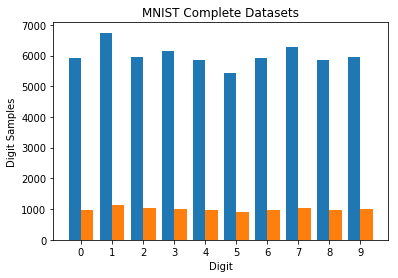

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from collections import Counter
import numpy as np

def plot_digit_histogram(dls, title=''):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_ylabel('Digit Samples')
    ax.set_xlabel('Digit')
    
    ys = []
    for dset in tqdm([dl.dataset for dl in dls], desc='Tabulating datasets'):
        _, y = consume_dataset(dset)
        ys.append(sorted(Counter(y)))
        
    H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

def consume_dataset(dataset):
    data = list(zip(*dataset))
    X = torch.stack(data[0])
    y = torch.tensor(data[1])
    return X, y

plot_digit_histogram([train_dl, test_dl], 'MNIST Complete Datasets')

The training data is reasonably well distributed, and the plots above confirm it. The test set counts are smaller by a factor of six, which reflects the relative sizes of the train and test datasets.

## Baseline: The Non-Federated Approach

To show baselines of non-federated learning, we'll train a model the traditional way, i.e., using just one worker. (Technically we'll using our federated code, but with one worker that's equivalent to non-federated learning.)

Let's get some basic housekeeping out of the way. These functions are convenient wrappers to simpulate systems to a certain endpoint (target accuracy or number of rounds) and show their output. (For every example in this post we use the full 10,000 sample MNIST test set to evaluate our models.)

In [8]:
# default training targets
default_n_rounds = 10
default_target_acc = 95.0

def run_mgr(mgr, n_rounds, target_acc=None):
    
    target_met = False;
    
    if (target_acc):
        print('{} manager training with {} worker(s) for up to {} rounds or {:.2%} accuracy.'.format(
                mgr.name, mgr.n_workers, n_rounds, target_acc / 100,))
    else:
        print('{} manager training with {} worker(s) for {} rounds.'.format(
                mgr.name, mgr.n_workers, n_rounds,))

    for i in trange(n_rounds, desc='Rounds'):
        if(mgr.verbose):
            print('Round', i)
        mgr.round()
        if(mgr.verbose):
            print('\tcombined\tloss: {:.4f}\tacc: {:.2%}\n'.format(
                mgr.history['test_loss'][-1], mgr.history['test_acc'][-1] / 100,))
            
        if(target_acc and (mgr.history['test_acc'][-1] >= target_acc)):
            target_met = True
            break;

    if(target_met):
        print('{} manager stopped: met accuracy target of {:.2%} after {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name, target_acc / 100, len(mgr.history['test_acc']), mgr.history['test_acc'][-1] / 100, mgr.history['test_loss'][-1],))
    else:
        print('{} manager trained {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name, len(mgr.history['test_acc']), mgr.history['test_acc'][-1] / 100, mgr.history['test_loss'][-1],))

def plot_mgr(mgrs, plot_workers=False):
    
    if not isinstance(mgrs, list):
        mgrs = [mgrs]
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_loss'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_loss'], label=(m.name, 'Worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend();
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_acc'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_acc'], label=(m.name, 'worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Accuracy")
    ax.legend();

    

### The Perfect World: All the Data in One Place

Now we can simulate an ideal non-federated situation where all of our data is in one place to train a master model. To do this we'll train a model using all of the data in the MNIST training set, 60,000 examples.

In [9]:
print("Dataset size: ", len(train_dl.dataset))

Dataset size:  60000


Remember, we're simulating *non-federated* learning by using a "federated" system with only one worker - these are functionally equivalent.

Non-Federated Full Dataset manager training with 1 worker(s) for up to 10 rounds or 95.00% accuracy.


Non-Federated Full Dataset manager stopped: met accuracy target of 95.00% after 3 rounds. (Test accuracy 95.70% and loss 0.1451.)


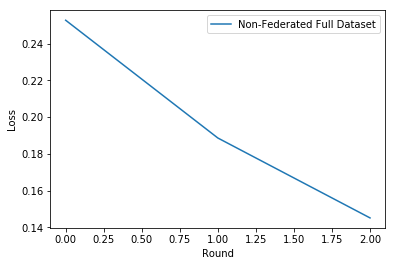

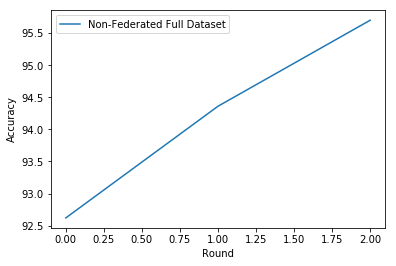

In [10]:
nonfed_alldata_mgr = FederatedManager('Non-Federated Full Dataset', [train_dl], test_dset, Net)

run_mgr(nonfed_alldata_mgr, default_n_rounds, target_acc=default_target_acc)

plot_mgr(nonfed_alldata_mgr)

So there's our baseline ideal-world situation, a non-federated model trained with all of the data in front of it. Let's check out less-ideal situations.

### Non-Federated Learning With Limited Data

In the real world, independent devices won't have all the data in front of them, and there will be bias in the data they see. E.g., a smartphone won't have access to other user's data to train a predictive text model. So let's see what happens when we simulate just one device with less data and some skew in that limited data.

The code below slices up the standard MNIST dataset and samples it without replacement to make ten subsets, then makes a dataloader for each of the ten subsets. The parameter `p` reflects the amount of skew in the dataset. There's also a dataset inspection function and an eval function for doing a whole simulation on one line.

In [11]:
from torch.utils.data import Subset

def make_fed_dloaders(dset, p=None, batch_size=64, shuffle=True):
    
    return [DataLoader(dset, batch_size, shuffle) for dset in make_fed_dsets(dset, p=p)]
    
def make_fed_dsets(dset, p=None):
    _, y = consume_dataset(dset)
    classes = set(y.numpy())
    n_classes = len(classes)
    idx_dset = index_to_dataset(y, p=p)
    dset_idx = [np.where(idx_dset == di)[0] for di in range(n_classes)]
    return [Subset(dset, di) for di in dset_idx]

def index_to_dataset(y, p=None):
    classes = set(y.numpy())
    n_classes = len(classes)
    p = p or 1/n_classes
    pnot = (1-p)/(n_classes-1)
    ps = np.full((n_classes, n_classes), pnot)
    np.fill_diagonal(ps, p)
    return np.array([np.random.choice(10, p=ps[yi]) for yi in y])

def check_dsets(dsets):
    for dset in dsets:
        _, y = consume_dataset(dset)
        print(Counter(y.numpy()))

def eval_new_mgr(name, train_dset, test_dset, p=0.0, n_rounds=50, target_acc=None, net=Net):
    dls = make_fed_dloaders(train_dset, p=p)
    mgr = FederatedManager(name, dls, test_dset, net)
    run_mgr(mgr, n_rounds, target_acc)
    plot_mgr(mgr)
    return mgr

We'll make a sample dataset with about 6,000 training samples, one tenth of the total MNIST training set. We'll arbitrarily choose the digit `4` for our overweighted digit, and a relatively mild skew value of `p=0.25`. 


Dataset size:  5980


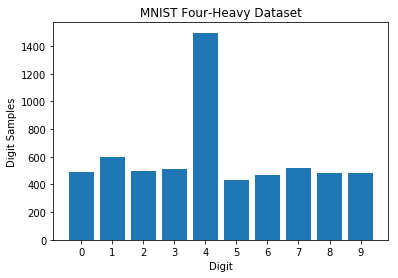

In [12]:
# Make a set of DataLoaders and use the one that is skewed toward 4s

nonfed_four_dl = make_fed_dloaders(train_dset, p=0.25)[4]

plot_digit_histogram([nonfed_four_dl], 'MNIST Four-Heavy Dataset')

print("Dataset size: ", len(nonfed_four_dl.dataset))

Here's what our dataset looks like. About a tenth of the samples and heavy on the 4s.

Now let's see what happens when we train with this subset. As before, we won't use any federation here, just less data and a little bias in the data we do have.

In [13]:
nonfed_four_mgr = FederatedManager('Non-Federated Fours Biased 0.25', [nonfed_four_dl], test_dset, Net)

run_mgr(nonfed_four_mgr, default_n_rounds, default_target_acc)

Non-Federated Fours Biased 0.25 manager training with 1 worker(s) for up to 10 rounds or 95.00% accuracy.



Non-Federated Fours Biased 0.25 manager trained 10 rounds. (Test accuracy 91.76% and loss 0.2851.)


Now let's compare this result to our ideal-world simulation

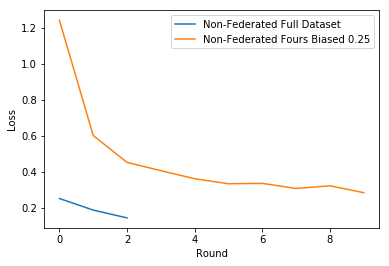

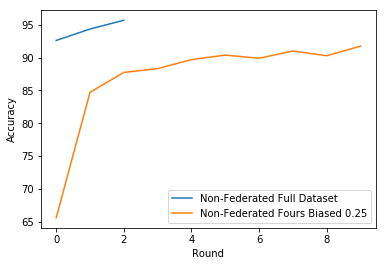

In [14]:
plot_mgr([nonfed_alldata_mgr, nonfed_four_mgr])

We should see that the limited-data model converges more slowly than the full data model. (I say "should" because these are randomly sampled datasets we're building - there's always a very small chance we'll get an unlucky draw.)

So how much of the problem here is bias in the data, and how much is the limited number of samples? Let's try a non-federated simulation with the same number of samples, but with no bias in the data.

In [15]:
nonfed_subset_mgr = FederatedManager('Non-Federated Subset Unbiased', [make_fed_dloaders(train_dset, p=0.0)[4]], test_dset, Net)
run_mgr(nonfed_subset_mgr, default_n_rounds, default_target_acc)

Non-Federated Subset Unbiased manager training with 1 worker(s) for up to 10 rounds or 95.00% accuracy.



Non-Federated Subset Unbiased manager trained 10 rounds. (Test accuracy 91.98% and loss 0.2797.)


Now let's compare our three Non-federated simulations.

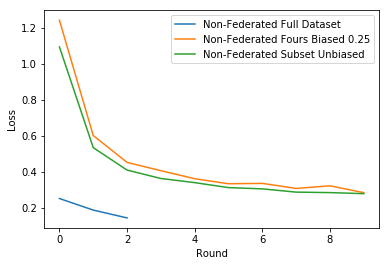

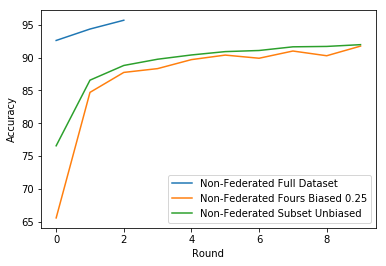

In [16]:
plot_mgr([nonfed_alldata_mgr, nonfed_four_mgr, nonfed_subset_mgr])

So it really is mostly the size of the dataset, not the bias, at least at `p=0.25`, that hurts performance. Federation gives us access to the signal in more data without moving the data.

# The Federated Approach

Now that we have a baseline using the traditional, i.e., non-federated, approach, let's see what federation gets us (and doesn't). We'll do the same MNIST task using federation.

## Splitting the Deck Into Piles

To illustrate federated learning we use several workers, each representing a remote device. We'll use ten workers here, and for now, we'll assume each of our ten workers has roughly equal types and quantities of data to the other nine (to do this we use `p=0` to reflect roughly even distribution of digit samples for any one worker).

In [17]:
fed_equal_dls = make_fed_dloaders(train_dset)

check_dsets([dl.dataset for dl in fed_equal_dls])

Counter({1: 673, 3: 647, 0: 629, 6: 611, 9: 598, 2: 594, 4: 589, 7: 576, 8: 569, 5: 564})
Counter({1: 637, 7: 619, 8: 619, 4: 604, 2: 600, 3: 594, 6: 582, 0: 579, 5: 558, 9: 558})
Counter({1: 696, 7: 669, 3: 636, 9: 599, 2: 596, 0: 591, 8: 591, 4: 582, 6: 561, 5: 534})
Counter({1: 640, 3: 627, 0: 619, 7: 602, 9: 595, 2: 575, 8: 554, 4: 536, 5: 535, 6: 525})
Counter({1: 685, 7: 623, 9: 621, 6: 609, 8: 594, 0: 581, 3: 576, 2: 573, 4: 554, 5: 530})
Counter({1: 659, 3: 658, 6: 650, 7: 627, 4: 614, 2: 606, 0: 601, 9: 582, 8: 582, 5: 513})
Counter({1: 705, 3: 640, 7: 637, 2: 617, 9: 593, 6: 581, 0: 572, 4: 569, 5: 562, 8: 562})
Counter({1: 679, 7: 655, 2: 628, 4: 617, 6: 613, 9: 600, 8: 596, 0: 586, 3: 570, 5: 536})
Counter({1: 720, 7: 636, 9: 615, 3: 614, 2: 604, 4: 599, 8: 592, 6: 578, 0: 568, 5: 542})
Counter({1: 648, 7: 621, 6: 608, 0: 597, 8: 592, 9: 588, 4: 578, 3: 569, 2: 565, 5: 547})


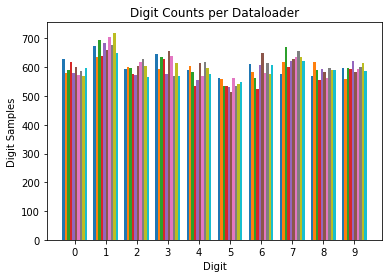

In [18]:
plot_digit_histogram(fed_equal_dls, 'Digit Counts per Dataloader')

So we can see that each of our ten workers has about the same number of each digit, i.e., the digit `5` is spread pretty evenly across the workers, and is probably lower in number for any given worker than the digit `1`, `1` being the most frequent digit in the MNIST set.

In [19]:
fed_equal_mgr = FederatedManager('Federated Unbiased', fed_equal_dls, test_dset, Net)

run_mgr(fed_equal_mgr, default_n_rounds, default_target_acc)

Federated Unbiased manager training with 10 worker(s) for up to 10 rounds or 95.00% accuracy.



Federated Unbiased manager trained 10 rounds. (Test accuracy 92.94% and loss 0.2480.)


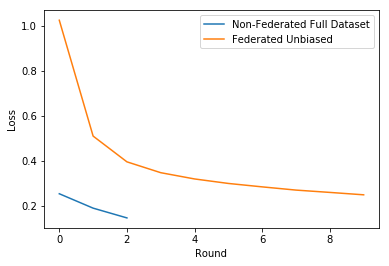

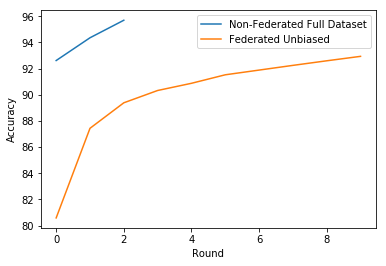

In [20]:
plot_mgr([nonfed_alldata_mgr, fed_equal_mgr])

The federated model converges, though a little slower than the non-federated version. But in the federated model, we don't have to move any data to a central system.

But this comparison isn't quite apples to apples. How does our fully federated model compare to a single user with limited data?

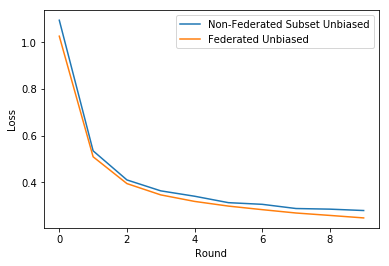

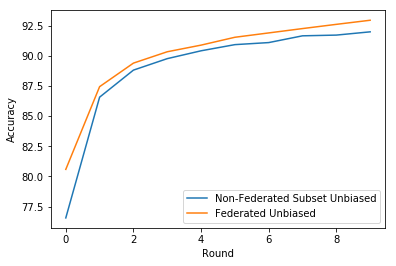

In [21]:
plot_mgr([nonfed_subset_mgr, fed_equal_mgr])

The federated manager, which uses all the data, but doesn't have all the data in one place, outperforms the non-federated model. In other words, performance improves with the additional signal made available by federation, and without the cost and risk of data transfer from the worker devices.

Of course, this isn't a guarantee in every case, but it shows the mechanics and potential of federation.

# Federation with Varying Example Distributions Per Worker

Now we've seen federation work with a dataset scattered across a number of workers. And we saw that its performance isn't substantially different from the non-federated approach, while decentralizing the work of training and limiting the amount of data transfered between the main manager and the workers.

But what if our workers don't have access to equal amounts of data? Let's explore that.

## Spliting the Decks into Uneven Piles

To test this, we need workers to have access to varying numbers of examples across training classes. So let's make a set of dataloaders that will give each worker more examples of a given digit than the other workers.

The parameter `p` sets the degree of bias toward the overweighted digit in each dataloader. Specifically, `p` is the odds of an example from a specific class being selected for a worker from the base dataset. We'll use `0.15` for `p` for now.

This results in a set of stacked dataloaders. The number of dataloaders is equal to the number of classes. Each dataloader is overweighted to one class.

In [22]:
fed_weighted_dls = make_fed_dloaders(train_dset, p=0.4)

Note that the dataloaders still give each worker roughly the same *total number* of examples. It's the number of examples *per class* that varies.

In [23]:
worker_example_counts = [len(dl.dataset) for dl in fed_weighted_dls]

print(worker_example_counts)

[5963, 6221, 6031, 6055, 6114, 5769, 5882, 6107, 5882, 5976]


And each of the 60,000 examples in the MNIST training dataset is allocated (without replacement) to a worker, so the total number of examples across workers is 60,000.

In [24]:
print(sum(worker_example_counts))

60000


Let's look at how the digit examples are allocated within each worker.

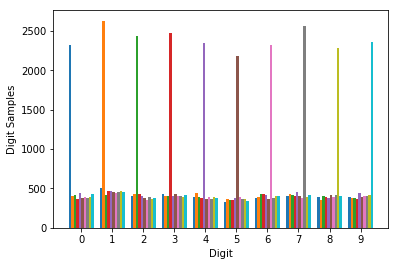

In [25]:
plot_digit_histogram(fed_weighted_dls)

We see here that worker 4, shown in purple, has more examples of the digit `4` than other workers. Likewise, worker 6, shown in pink, has more examples of the digit `6` than other workers.

Here are the actual counts from the dataloaders for workers 4 and 6. You can see that the most frequent examples in those dataloaders are `4` and `6`, respectively.

In [26]:
check_dsets([fed_weighted_dls[4].dataset])

check_dsets([fed_weighted_dls[6].dataset])

Counter({4: 2342, 1: 462, 7: 449, 0: 446, 9: 440, 6: 412, 2: 408, 3: 398, 8: 380, 5: 377})
Counter({6: 2325, 1: 438, 9: 410, 3: 399, 8: 397, 4: 396, 0: 392, 5: 386, 7: 380, 2: 359})


And if you're curious, here are all of the worker counts.

In [27]:
check_dsets([dl.dataset for dl in fed_weighted_dls])

Counter({0: 2328, 1: 501, 3: 431, 7: 409, 2: 403, 9: 393, 4: 392, 8: 392, 6: 380, 5: 334})
Counter({1: 2631, 4: 440, 2: 431, 7: 429, 3: 399, 0: 398, 6: 387, 9: 383, 5: 367, 8: 356})
Counter({2: 2431, 6: 427, 7: 421, 1: 418, 0: 411, 3: 404, 8: 402, 4: 386, 9: 383, 5: 348})
Counter({3: 2474, 1: 465, 6: 429, 2: 424, 7: 401, 8: 396, 4: 376, 9: 369, 0: 367, 5: 354})
Counter({4: 2342, 1: 462, 7: 449, 0: 446, 9: 440, 6: 412, 2: 408, 3: 398, 8: 380, 5: 377})
Counter({5: 2189, 1: 458, 3: 426, 8: 412, 7: 402, 9: 393, 0: 377, 2: 374, 6: 370, 4: 368})
Counter({6: 2325, 1: 438, 9: 410, 3: 399, 8: 397, 4: 396, 0: 392, 5: 386, 7: 380, 2: 359})
Counter({7: 2565, 1: 451, 8: 418, 9: 407, 3: 401, 2: 385, 6: 376, 0: 375, 4: 366, 5: 363})
Counter({8: 2289, 1: 466, 9: 412, 6: 410, 0: 397, 4: 393, 7: 392, 3: 387, 5: 368, 2: 368})
Counter({9: 2359, 1: 452, 0: 432, 7: 417, 3: 412, 8: 409, 6: 402, 4: 383, 2: 375, 5: 335})


Now let's see how the federated approach performs with variation in the worker datasets.

Fed Bias manager training with 10 worker(s) for up to 10 rounds or 95.00% accuracy.



Fed Bias manager trained 10 rounds. (Test accuracy 92.63% and loss 0.2616.)


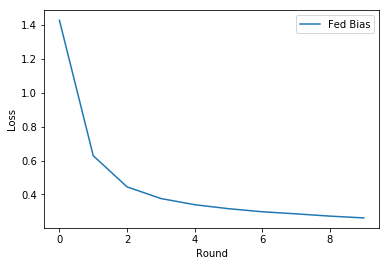

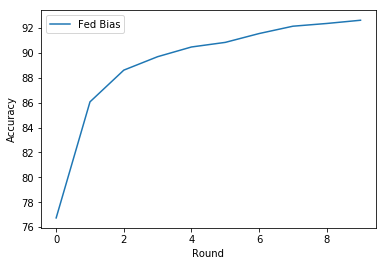

In [28]:
fed_weighted_mgr = FederatedManager('Fed Bias', fed_weighted_dls, test_dset, Net)
run_mgr(fed_weighted_mgr, default_n_rounds, default_target_acc)
plot_mgr(fed_weighted_mgr)

#fed_060_mgr = eval_new_mgr('Fed Bias 0.60', train_dset, test_dset, p=0.60, num_rounds=10, target_acc=None)

#plot_mgr(fed_060_mgr)

The biased federated model converges just fine.

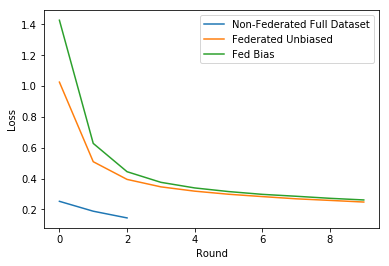

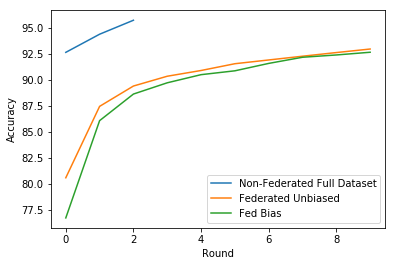

In [29]:
plot_mgr([nonfed_alldata_mgr, fed_equal_mgr, fed_weighted_mgr])

Though it converges a little slower than the unbiased federated model.

Let's take a closer look at how performance changes with increasingly biased data.

Fed Bias 0.0 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.


Fed Bias 0.0 manager stopped: met accuracy target of 90.00% after 4 rounds. (Test accuracy 90.13% and loss 0.3552.)
Fed Bias 0.1 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.


Fed Bias 0.1 manager stopped: met accuracy target of 90.00% after 4 rounds. (Test accuracy 90.26% and loss 0.3504.)
Fed Bias 0.6 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.


Fed Bias 0.6 manager stopped: met accuracy target of 90.00% after 6 rounds. (Test accuracy 90.11% and loss 0.3508.)
Fed Bias 0.9 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 0.9 manager trained 10 rounds. (Test accuracy 88.17% and loss 0.4577.)
Fed Bias 0.95 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 0.95 manager trained 10 rounds. (Test accuracy 84.73% and loss 0.6624.)
Fed Bias 0.98 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 0.98 manager trained 10 rounds. (Test accuracy 79.80% and loss 1.0652.)
Fed Bias 0.999 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 0.999 manager trained 10 rounds. (Test accuracy 70.09% and loss 1.6370.)
Fed Bias 1.0 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 1.0 manager trained 10 rounds. (Test accuracy 68.33% and loss 1.7520.)



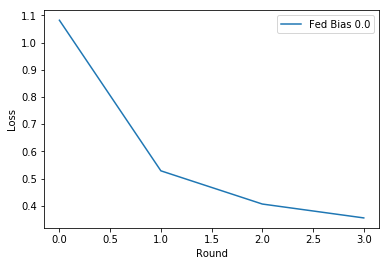

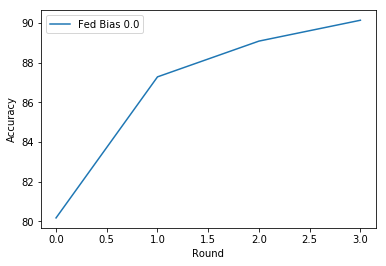

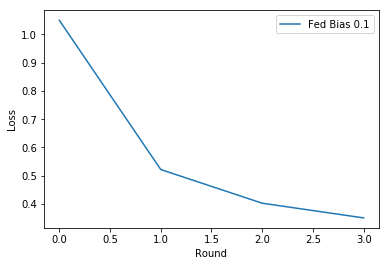

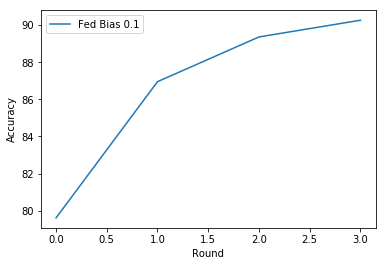

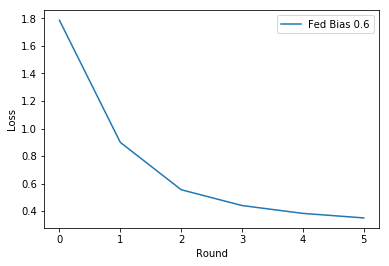

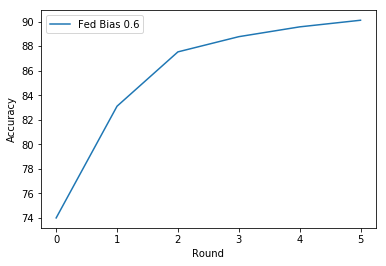

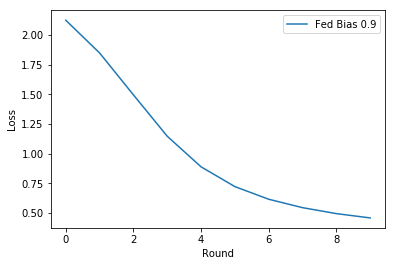

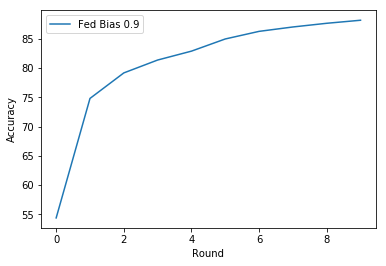

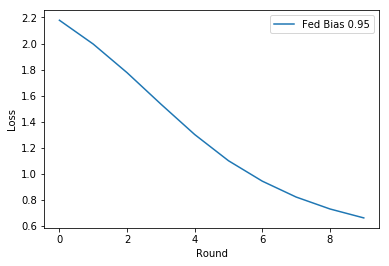

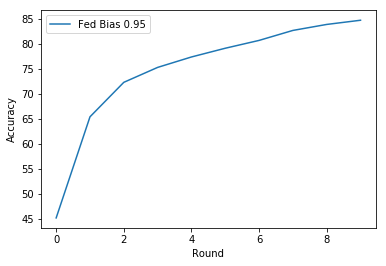

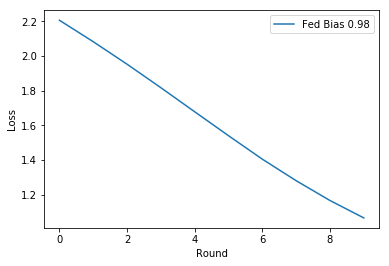

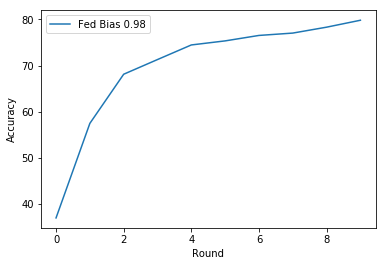

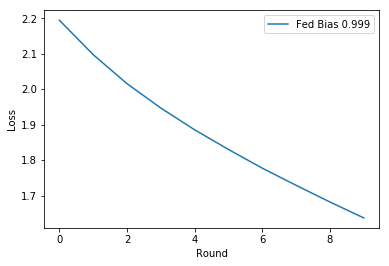

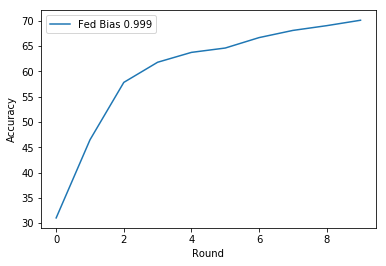

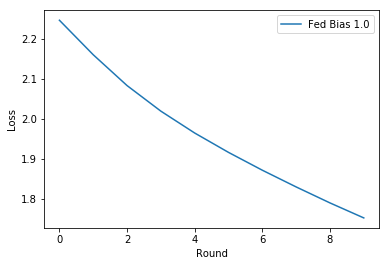

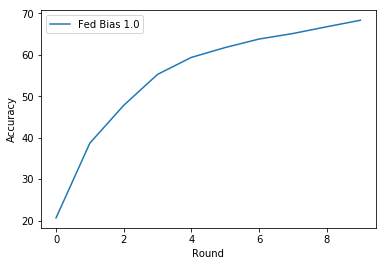

In [30]:
mgrs = [eval_new_mgr(('Fed Bias '+ str(x)), train_dset, test_dset, p=x, n_rounds=10, target_acc=90.0) for x in tqdm([0.0, 0.1, 0.6, 0.9, 0.95, 0.98, 0.999, 1.0])]


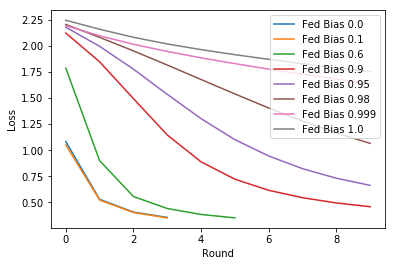

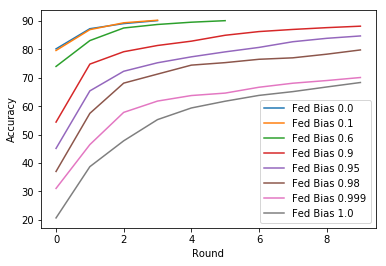

In [31]:
plot_mgr(mgrs)

The federated models converge even with very heavily biased datasets per worker. Unsurprisingly, it takes longer to hit a given target accuracy. But even when the datasets are completely biased, that is, each worker sees examples from *exactly one class*, federation works.

We expect that a sole learner with access to samples of only one class will perform poorly on a ten-class task.

Non-Federated Fours Biased 1.0 manager training with 1 worker(s) for up to 10 rounds or 95.00% accuracy.



Non-Federated Fours Biased 1.0 manager trained 10 rounds. (Test accuracy 9.82% and loss 9.1699.)


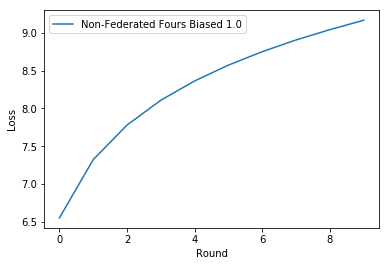

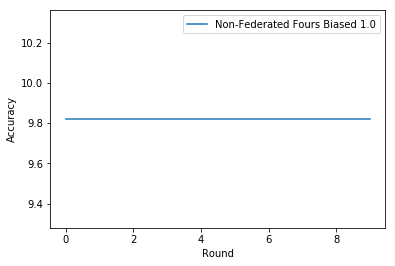

In [32]:
nonfed_allfours_dl = make_fed_dloaders(train_dset, p=1.0)[4]

nonfed_allfours_mgr = FederatedManager('Non-Federated Fours Biased 1.0', [nonfed_allfours_dl], test_dset, Net)

run_mgr(nonfed_allfours_mgr, default_n_rounds, default_target_acc)

plot_mgr(nonfed_allfours_mgr)

#nonfed_allfours_mgr = eval_new_mgr('Non-Federated Fours Biased 1.0', train_dset, test_dset, p=1.0, n_rounds=default_n_rounds, target_acc=default_target_acc)

No surprise - it doesn't work.

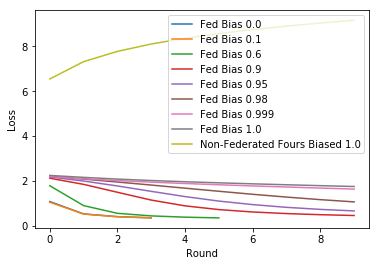

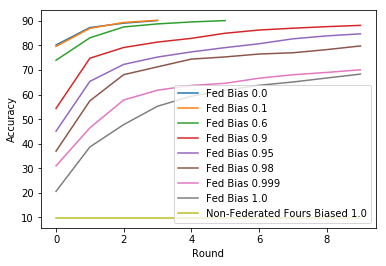

In [33]:
mgrs.append(nonfed_allfours_mgr)

plot_mgr(mgrs)

In cases of heavily skewed datasets, federation enables the master model to incorporate signal from sources that operate only as sensors for outlier data.

# Conclusion
TODO: WRAP UP THE BLOG POST HERE. EVERYTHING BELOW IS PART TWO OR THREE